In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.4 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 6.8 MB 34.6 MB/s 
     |████████████████████████████████| 895 kB 50.2 MB/s 
     |████████████████████████████████| 596 kB 33.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os, re, torch, html, tempfile, copy, json, math, shutil, tarfile, tempfile, sys, random, pickle, string
from torch import nn
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss, ReLU, DataParallel
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from transformers import RobertaTokenizer, BertForTokenClassification, BertTokenizer, BertConfig, BertModel, WordpieceTokenizer, XLNetTokenizer, AutoTokenizer, get_linear_schedule_with_warmup
from transformers.file_utils import cached_path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import time
from copy import deepcopy
from sklearn.metrics import classification_report
import seaborn as sn

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer.tokenize("unknown")

['unknown']

In [ ]:
def load_bioscope_data():
        with open('bioscope.papers.columns.txt', 'r') as f, open('bioscope.papers.columns.txt_', 'w') as fo:
            for line in f:
                fo.write(line.replace('"', '').replace("'", ""))
        df_train_extra = pd.read_csv("bioscope.papers.columns.txt_" , names=["Text", "Sentence_N", "Word_N", "Word", "Label", "Scope", "/"], quotechar='"' , delimiter="\t", engine="python")
        df_train_extra.drop(["Scope", "/"], axis=1, inplace=True)
        df_train_extra["Label"].loc[(df_train_extra['Label'] == '_')] = 'O'
        df_train_extra["Label"].loc[(df_train_extra['Label'] == 'B-negation')] = 'B-NEG'
        df_train_extra["Label"].loc[(df_train_extra['Label'] == 'I-negation')] = 'I-NEG'
        df_train_extra["Text"] = df_train_extra["Text"].astype(str)
        df_train_extra["Word"] = df_train_extra["Word"].astype(str)
        df_train_extra["Label"] = df_train_extra["Label"].astype(str)
        df_train_extra = df_train_extra.dropna()

        return df_train_extra

def process_labels(label):
    if label == "O":
        return 0
    elif label=="B-NEG":
        return 1
    elif label == "I-NEG":
        return 2
    else:
        print(label)
        print("Error")
        return 0

# def undersampling(train_sents, train_labels):

#     new_sents = []
#     new_labels = []

#     for idx, sent in enumerate(train_sents):
#         labels = train_labels[idx]
        
#         if 2 in labels or 3 in labels:
#             new_sents.append(sent)
#             new_labels.append(labels)

#     print( "Number of sentences selected:", len(new_sents) )

#     return new_sents, new_labels

def tokenize_words(word):
    token_list = tokenizer.tokenize(word)
    return token_list

def tokenize_BERT(df, tokenizer):
    '''
    Tokenizes each word in the original data and expands the dataframe for each new token.

    :param df: the original dataframe
    :return: the updated dataframe
    '''

    df["Label"] = df["Label"].apply( lambda x: process_labels( x ) )

    df["Id"] = df["Text"]+ "_" +df["Sentence_N"].astype(str)

    df["Bert_token"] = df["Word"].apply( lambda x: tokenize_words(x) )
    df = df.explode("Bert_token").reset_index(drop=True)

    df = df[["Id", "Bert_token", "Label"]]
    grouped_df = df.groupby('Id').agg(lambda x: list(x)).reset_index()

    return grouped_df["Bert_token"].to_list(), grouped_df["Label"].to_list()


def add_padding_and_masks(sents, labels, maximum_length):

    sents = pad_sequences(sents, maxlen = maximum_length,  padding = "post", value = "3", dtype=object )
    labels = pad_sequences(labels, maxlen = maximum_length,  padding = "post", value = "3", dtype=object )

    masks = []

    # for sent in sents:
    #     att_mask = [int(token_id > 0) for token_id in sent]
    #     masks.append( att_mask )

    return sents, labels, masks

def tokenize_df(df, tokenizer):

    sents, labels = tokenize_BERT(df, tokenizer)

    for idx,sent in enumerate(sents):
        sents[idx].insert(0,101)
        sents[idx].append( 102)

        labels[idx].insert(0,0)
        labels[idx].append(0)

    return sents,labels

def load_train_val_data(tokenizer):
    global MAX_LENGTH

    train_df = pd.read_table( 'SEM-2012-SharedTask-CD-SCO-training-simple.v2.txt', \
                             names=['Text','Sentence_N','Word_N','Word', 'Label'])
    
    bioscope_df = load_bioscope_data()

    train_df = pd.concat([train_df, bioscope_df]).reset_index(drop=True)

    dev_df = pd.read_table( 'SEM-2012-SharedTask-CD-SCO-dev-simple.v2.txt', \
                             names=['Text','Sentence_N','Word_N','Word', 'Label'])
    
    df_test1 = pd.read_table( 'SEM-2012-SharedTask-CD-SCO-test-circle.txt',
        names=['Text','Sentence_N','Word_N','Word', 'Label'] )
    
    df_test2 = pd.read_table( 'SEM-2012-SharedTask-CD-SCO-test-cardboard.txt',
                             names=['Text','Sentence_N','Word_N','Word', 'Label'])

    tests = [df_test1, df_test2]
    test_df = pd.concat(tests).reset_index(drop=True)

    train_sents, train_labels = tokenize_df(train_df, tokenizer)
    dev_sents, dev_labels = tokenize_df(dev_df, tokenizer)
    test_sents, test_labels = tokenize_df(test_df, tokenizer)

    max_length = max( max( [ len(x) for x in train_sents ] ), max( [ len(x) for x in dev_sents ] ), max( [ len(x) for x in test_sents ] ) )
    MAX_LENGTH = deepcopy(max_length)

    train_sents, train_labels, train_masks = add_padding_and_masks(train_sents, train_labels, max_length)
    dev_sents, dev_labels, dev_masks = add_padding_and_masks(dev_sents, dev_labels, max_length)
    test_sents, test_labels, test_masks = add_padding_and_masks(test_sents, test_labels, max_length)


    return train_sents, train_masks, train_labels, dev_sents, dev_masks, dev_labels, test_sents, test_masks, test_labels
    


In [ ]:
test_predictions = pd.read_csv("test_predictions.csv", header = None, delimiter = ";", dtype = "Int64")
test_predictions = test_predictions.iloc[:,0].tolist()

true_test_labels = pd.read_csv("true_labels.csv", header = None, delimiter = ";", dtype = "Int64")
true_test_labels = true_test_labels.iloc[:,0].tolist()

dev_predictions = pd.read_csv("dev_predictions.csv", header = None, delimiter = ";", dtype = "Int64")
dev_predictions = dev_predictions.iloc[:,0].tolist()


true_dev_labels = pd.read_csv("true_dev_labels.csv", header = None, delimiter = ";", dtype = "Int64")
true_dev_labels = true_dev_labels.iloc[:,0].tolist()



tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def revert_labels(label):
    if label == 0:
        return "O"
    elif label==1:
        return "B-NEG"
    elif label == 2:
        return "I-NEG"
    elif label == "3":
        return "Padding"
    else:
        print(label)
        print("Error")
        return 0

train_sents, train_masks, train_labels, dev_sents, dev_masks, dev_labels, test_sents, test_masks, test_labels  = load_train_val_data(tokenizer)

test_df = pd.DataFrame(list(zip( test_sents.flatten(), test_labels.flatten() )), columns = ["Bert_token", "Label"] )
dev_df = pd.DataFrame(list(zip( dev_sents.flatten(), dev_labels.flatten() )), columns = ["Bert_token", "Label"] )

test_df["Label"] = test_df["Label"].apply( lambda x: revert_labels(x) )
dev_df["Label"] = dev_df["Label"].apply( lambda x: revert_labels(x) )



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
def revert_labels(label):
    if label == 0:
        return "O"
    elif label==1:
        return "B-NEG"
    elif label == 2:
        return "I-NEG"
    elif label == 3:
        return "Padding"
    else:
        print(label)
        print("Error")
        return 0

predictions_test_df = pd.DataFrame(list(zip(true_test_labels, test_predictions ) ), columns = ["Test_labels", "Test_predictions"])
predictions_test_df["Test_labels"] = predictions_test_df["Test_labels"].apply( lambda x: revert_labels(x) )
predictions_test_df["Test_predictions"] = predictions_test_df["Test_predictions"].apply( lambda x: revert_labels(x) )

predictions_dev_df = pd.DataFrame(list(zip(true_dev_labels, dev_predictions ) ), columns = ["Dev_labels", "Dev_predictions"])
predictions_dev_df["Dev_labels"] = predictions_dev_df["Dev_labels"].apply( lambda x: revert_labels(x) )
predictions_dev_df["Dev_predictions"] = predictions_dev_df["Dev_predictions"].apply( lambda x: revert_labels(x) )

new_test_df = pd.concat([test_df, predictions_test_df], axis = 1)
new_dev_df = pd.concat([dev_df, predictions_dev_df], axis = 1)

In [ ]:
new_test_df["Difference"] = new_test_df.apply( lambda x: 1 if x["Test_labels"] != x["Test_predictions"] else 0, axis = 1)
new_dev_df["Difference"] = new_dev_df.apply( lambda x: 1 if x["Dev_labels"] != x["Dev_predictions"] else 0, axis = 1)

print(new_dev_df.head())

  Bert_token Label Dev_labels Dev_predictions  Difference
0        101     O          O               O           0
1          1     O          O               O           0
2          .     O          O               O           0
3        the     O          O               O           0
4   singular     O          O               O           0


In [ ]:
new_test_df.to_csv("test_df_EA.csv", sep = ";", index = False)
new_dev_df.to_csv("dev_df_EA.csv", sep = ";", index = False)

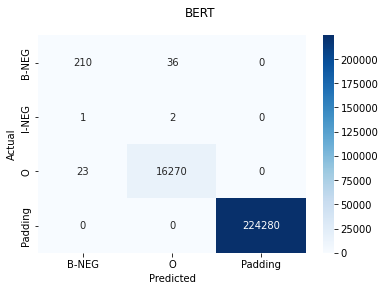

In [ ]:
def revert_labels(label):
    if label == 0:
        return "O"
    elif label==1:
        return "B-NEG"
    elif label == 2:
        return "I-NEG"
    elif label == 3:
        return "Padding"
    else:
        print(label)
        print("Error")
        return 0


dev_predictions = pd.read_csv("dev_predictions.csv", header = None, delimiter = ";", dtype = "Int64")
dev_predictions = dev_predictions.iloc[:,0].tolist()


true_dev_labels = pd.read_csv("true_dev_labels.csv", header = None, delimiter = ";", dtype = "Int64")
true_dev_labels = true_dev_labels.iloc[:,0].tolist()

predictions_dev_df = pd.DataFrame(list(zip(true_dev_labels, dev_predictions ) ), columns = ["Dev_labels", "Dev_predictions"])
predictions_dev_df["Dev_labels"] = predictions_dev_df["Dev_labels"].apply( lambda x: revert_labels(x) )
predictions_dev_df["Dev_predictions"] = predictions_dev_df["Dev_predictions"].apply( lambda x: revert_labels(x) )

confusion_matrix = pd.crosstab(predictions_dev_df['Dev_labels'], predictions_dev_df['Dev_predictions'], rownames=['Actual'], colnames = ['Predicted'], dropna = False)
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels = True, yticklabels = True)
plt.suptitle('BERT')
#plt.show()
plt.savefig('BERT_de.pdf')